In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [ ]:
dataset = []
for folder in ["/content/drive/MyDrive/Major Project /set_a.zip/**","/content/drive/MyDrive/Major Project /set_b.zip/"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  404 non-null    object 
 1   label     404 non-null    object 
 2   offset    404 non-null    float64
dtypes: float64(1), object(2)
memory usage: 12.6+ KB


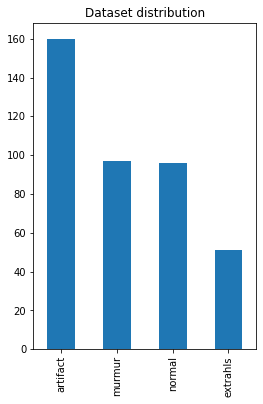

In [ ]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 323
Test: 81


In [ ]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [ ]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 81/81 [00:08<00:00,  9.67it/s]

X train: (323, 40, 130)
X test: (81, 40, 130)


In [ ]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),y = y_train )

In [ ]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (323, 40, 130, 1)
Y train: (323, 4)
X test: (81, 40, 130, 1)
Y test: (81, 4)


In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 39, 129, 32)       160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 19, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 19, 64, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 63, 64)        8256      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 9, 31, 64)        0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 9, 31, 64)        

In [ ]:
from tensorflow import keras
adam = keras.optimizers.Adam(1e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/300
3/3 [==============================] - 3s 580ms/step - loss: 16.8991 - accuracy: 0.2848 - val_loss: 4.5714 - val_accuracy: 0.1358
Epoch 2/300
3/3 [==============================] - 2s 503ms/step - loss: 13.7105 - accuracy: 0.3065 - val_loss: 2.0998 - val_accuracy: 0.5185
Epoch 3/300
3/3 [==============================] - 2s 495ms/step - loss: 6.0637 - accuracy: 0.4737 - val_loss: 1.2918 - val_accuracy: 0.2963
Epoch 4/300
3/3 [==============================] - 2s 722ms/step - loss: 2.9926 - accuracy: 0.4365 - val_loss: 2.0039 - val_accuracy: 0.2716
Epoch 5/300
3/3 [==============================] - 2s 658ms/step - loss: 3.1236 - accuracy: 0.4087 - val_loss: 0.8725 - val_accuracy: 0.5185
Epoch 6/300
3/3 [==============================] - 2s 529ms/step - loss: 1.4710 - accuracy: 0.5232 - val_loss: 0.8135 - val_accuracy: 0.6790
Epoch 7/300
3/3 [==============================] - 2s 501ms/step - loss: 1.5683 - accuracy: 0.5604 - val_loss: 0.7919 - val_accuracy: 0.7037
Epoch 8/300

Text(0.5, 1.0, 'Accuracy Curves')

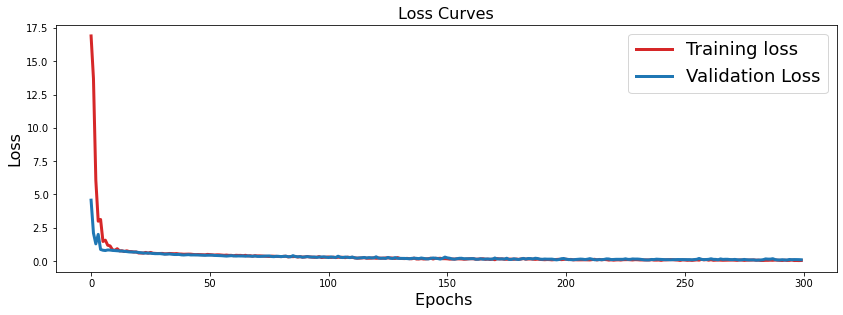

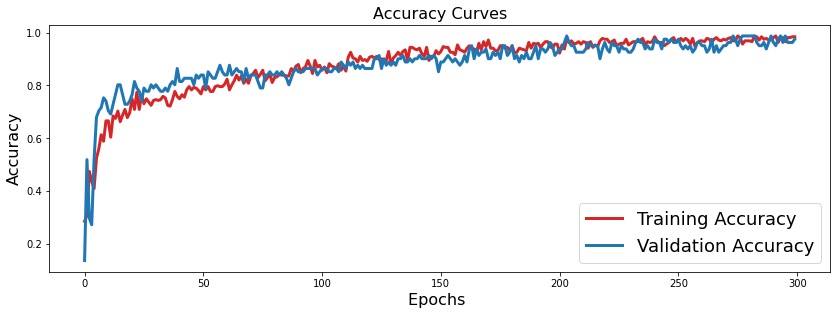

In [ ]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 28ms/step - loss: 0.0981 - accuracy: 0.9753
Test loss: 0.09812549501657486
Test accuracy: 0.9753086566925049


In [ ]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

3/3 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

    artifact       0.97      1.00      0.99        39
    extrahls       1.00      0.92      0.96        12
      murmur       1.00      1.00      1.00        19
      normal       0.91      0.91      0.91        11

    accuracy                           0.98        81
   macro avg       0.97      0.96      0.96        81
weighted avg       0.98      0.98      0.98        81



In [ ]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

In [ ]:
print(classes)

['artifact' 'extrahls' 'murmur' 'normal']


In [ ]:
# # load and evaluate a saved model
from keras.models import load_model
 
# # load model
model = load_model("heartbeat_classifier (normalised).h5")

# File to be classified
classify_file = "extrahls__201101241433.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)
print(classes_x)

1/1 [==============================] - 0s 95ms/step
[[8.4385341e-05 9.9986517e-01 1.7917781e-06 4.8652448e-05]]
[1]


In [ ]:
#@title
pred_class=model.predict(x_test) 
classes_x=np.argmax(pred_class,axis=1)
if classes_x==0:
    print("Artifact")
elif classes_x==1:
    print("Extrahl")
elif classes_x==2:
    print("Murmur")
else:
    print("Normal")

1/1 [==============================] - 0s 18ms/step
Extrahl
